# 1. Environment Setup

In [77]:
# Install required packages if running in Colab or Jupyter
!pip install opencv-python numpy matplotlib


# 2. Data Download and Display

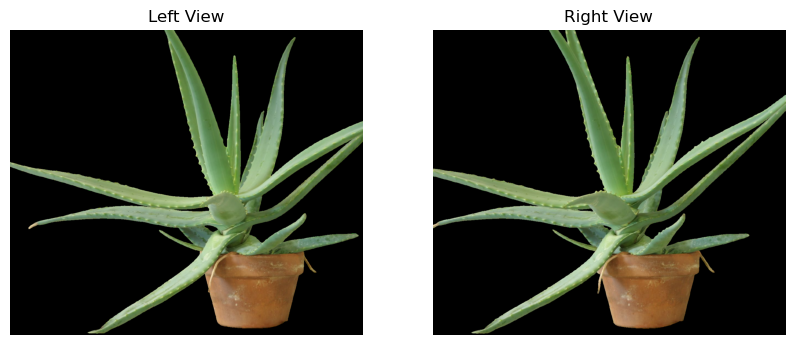

In [87]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import os

# Download images to local files if not present
if not os.path.exists('img1.jpg'):
    urlretrieve('https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeL.jpg', 'img1.jpg')
if not os.path.exists('img2.jpg'):
    urlretrieve('https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeR.jpg', 'img2.jpg')

# Read images (BGR)
img1_bgr = cv2.imread('img1.png')
img2_bgr = cv2.imread('img2.png')
if img1_bgr is None or img2_bgr is None:
    raise FileNotFoundError("Could not read img1.jpg or img2.jpg. Check the download step or paths.")

# Convert to RGB for matplotlib display
img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)

# Show images side-by-side
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img1); plt.title('Left View'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2); plt.title('Right View'); plt.axis('off')
plt.show()


# 3. Stage 1: SIFT Keypoint Detection (Feature Hunt)

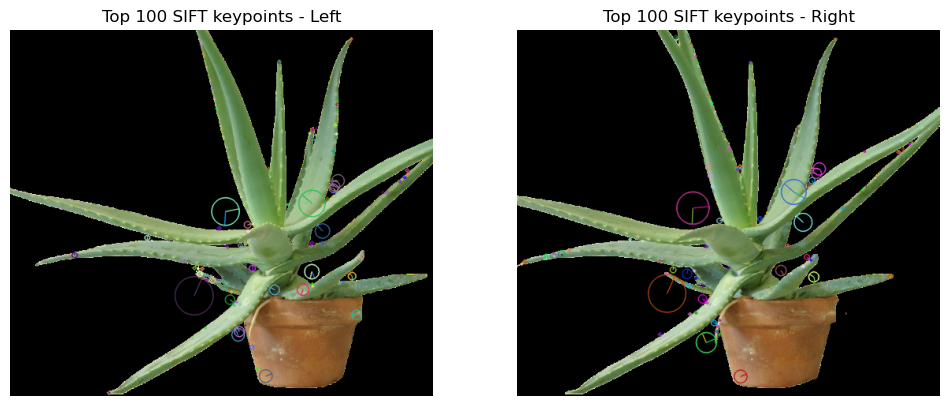

True

In [79]:
# Create SIFT detector (requires opencv-contrib-python)
sift = cv2.SIFT_create(nfeatures=5000)

gray1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Sort keypoints by response (strength), keep top-100
kp1_sorted = sorted(kp1, key=lambda x: -x.response)[:100]
kp2_sorted = sorted(kp2, key=lambda x: -x.response)[:100]

# Draw keypoints for visualization (use cv2.drawKeypoints on BGR then convert)
img1_kp = cv2.drawKeypoints(img1_bgr, kp1_sorted, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2_bgr, kp2_sorted, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Convert to RGB for plotting
img1_kp_rgb = cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB)
img2_kp_rgb = cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img1_kp_rgb); plt.title('Top 100 SIFT keypoints - Left'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img2_kp_rgb); plt.title('Top 100 SIFT keypoints - Right'); plt.axis('off')
plt.show()

# Save if you want
cv2.imwrite('img1_sift.jpg', cv2.cvtColor(img1_kp_rgb, cv2.COLOR_RGB2BGR))
cv2.imwrite('img2_sift.jpg', cv2.cvtColor(img2_kp_rgb, cv2.COLOR_RGB2BGR))


# 4. Stage 2: Feature Matching (Feature Matchmaker)

Total raw matches (knn): 305, Good matches after ratio test: 81


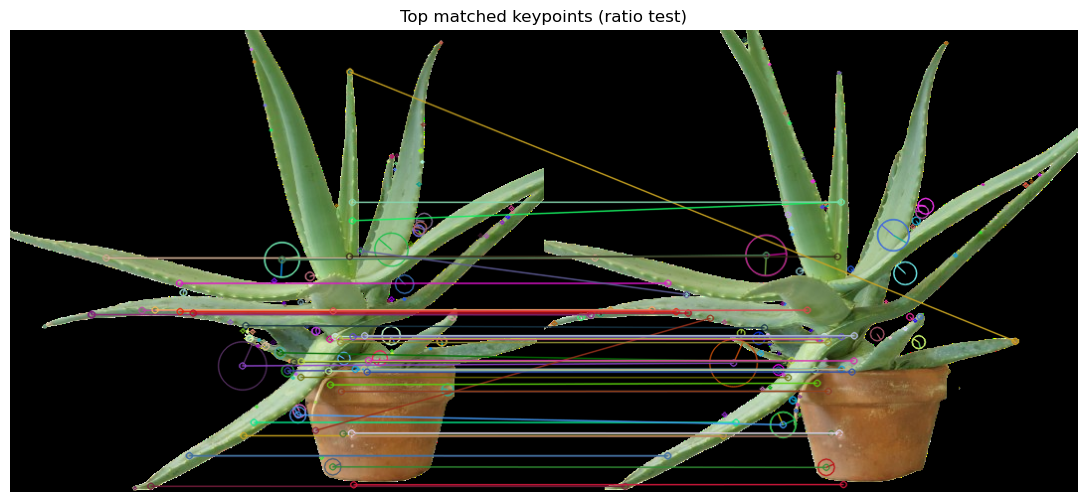

True

In [80]:
# Create BFMatcher for SIFT descriptors (L2 norm)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Find the two nearest matches for each descriptor (for ratio test)
matches_knn = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good_matches = []
ratio_thresh = 0.75
for m,n in matches_knn:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

print(f"Total raw matches (knn): {len(matches_knn)}, Good matches after ratio test: {len(good_matches)}")

# Draw top N matches for visualization
topN = 50
img_matches = cv2.drawMatches(img1_kp_rgb, kp1, img2_kp_rgb, kp2, good_matches[:topN], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(14,6))
plt.imshow(img_matches); plt.axis('off'); plt.title('Top matched keypoints (ratio test)')
plt.show()

# Save
cv2.imwrite('output_match.jpg', cv2.cvtColor(img_matches, cv2.COLOR_RGB2BGR))


# 5. Stage 3: Fundamental Matrix Estimation (Geometry Guru)

In [81]:
# Collect matched points (use keypoint coordinates)
pts1 = []
pts2 = []
for m in good_matches:
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

# Compute Fundamental matrix with RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=0.5, confidence=0.99, maxIters=2000)
if F is None:
    raise RuntimeError("Fundamental matrix computation failed. Possibly not enough good matches.")

# mask is 0/1 array marking inliers — keep only inliers
mask = mask.ravel()
inlier_pts1 = pts1[mask==1]
inlier_pts2 = pts2[mask==1]
print(f"F shape: {F.shape}, total matches: {len(pts1)}, inliers after RANSAC: {inlier_pts1.shape[0]}")


F shape: (3, 3), total matches: 81, inliers after RANSAC: 37


# 6. Stage 4: Essential Matrix and Pose Estimation (Pose Explorer)

In [82]:
# Simple intrinsic matrix (example)
h, w = gray1.shape
# Focal length approximated, principal point at center
f = 1200  # adjust if you know true focal length
cx, cy = w/2, h/2
K = np.array([[f, 0, cx],
              [0, f, cy],
              [0, 0,  1]], dtype=float)

# Compute Essential matrix from F: E = K.T * F * K
E = K.T @ F @ K

# Need to provide points in normalized pixel coords? recoverPose expects pixel coords with K provided.
# Use only inlier points
inlier_pts1_int = inlier_pts1
inlier_pts2_int = inlier_pts2

# recoverPose returns R, t, and a mask of inliers used in pose recovery
retval, R, t, pose_mask = cv2.recoverPose(E, inlier_pts1_int, inlier_pts2_int, K)

print("Recovered pose:")
print("R =\n", R)
print("t =\n", t.ravel())

# Save pose (human-readable)
with open('pose.txt','w') as ftxt:
    ftxt.write("R:\n")
    np.savetxt(ftxt, R, fmt='%.6f')
    ftxt.write("\nt:\n")
    np.savetxt(ftxt, t.ravel()[None], fmt='%.6f')


Recovered pose:
R =
 [[ 0.99920339 -0.03970955 -0.00396694]
 [ 0.03979002  0.99894712  0.02283412]
 [ 0.00305603 -0.02297377  0.9997314 ]]
t =
 [-0.55316364  0.14384304  0.82056027]


# 7. Stage 5: 3D Reconstruction (3-D Builder)

In [83]:
# Construct projection matrices P1 and P2 using R and t
# First camera at origin: P1 = K [I | 0]
P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
# Second camera: P2 = K [R | t]
P2 = K @ np.hstack((R, t))

# Convert inlier_pts to homogeneous normalized coordinates if necessary
# OpenCV expects points as 2xN float arrays
pts1_h = inlier_pts1.T  # shape (2, N)
pts2_h = inlier_pts2.T

# Triangulate
points_hom = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)  # 4xN
# Convert to 3D by dividing by last row
points_3d = points_hom[:3, :] / points_hom[3, :]

print("Triangulated 3D points shape:", points_3d.shape)  # (3, N)

# Save a sample of points for inspection
np.savetxt('reconstruction_sample.txt', points_3d.T[:200], fmt='%.6f')


Triangulated 3D points shape: (3, 37)


# 8. Stage 6: Creativity Challenge (Open-Ended)

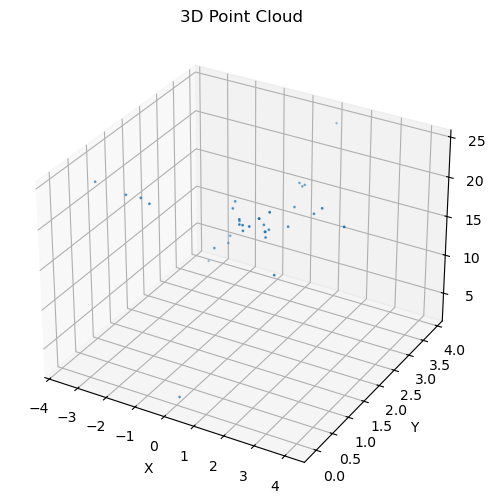

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

x = points_3d[0,:]
y = points_3d[1,:]
z = points_3d[2,:]

# A small scatter, color by depth
sc = ax.scatter(x, y, z, s=1)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.title('3D Point Cloud')
plt.savefig('reconstruction.png', dpi=200)
plt.show()


# Cell 9 — Bonus: Depth Colorizer (fix undefined points_3d references)

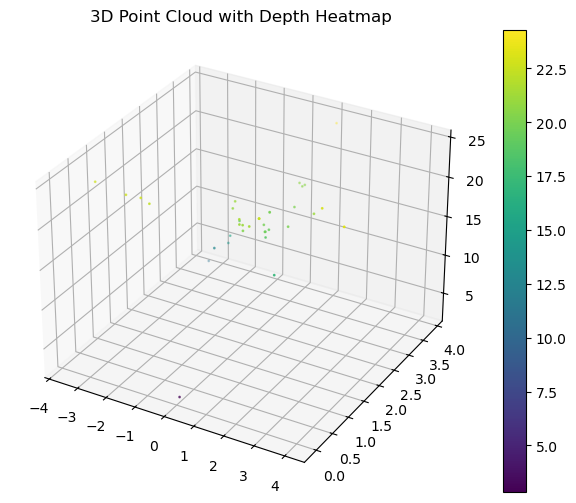

In [ ]:
# Depth Colorizer: Color points by Z-value (depth)
cz = points_3d[2,:]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points_3d[0], points_3d[1], points_3d[2], c=cz, s=1)
fig.colorbar(sc)
plt.title('3D Point Cloud with Depth Heatmap')
plt.savefig('depth_heatmap.png', dpi=200)
plt.show()
